## RUL prediction using LSTM

In this notebook, we will use 1D CNN to predict RUL of NASA's turbofan engine dataset FD001. We will show the implementation without going into the theory of CNN.

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

np.random.seed(34)

2023-12-27 15:28:21.994491: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-27 15:28:21.994544: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-27 15:28:21.997658: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-27 15:28:22.210553: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
print("Tensorflow Version: ", tf.__version__)
print("Numpy version: ", np.__version__)
print("Pandas version: ", pd.__version__)
print("Scikit-learn version: ", sklearn.__version__)

Tensorflow Version:  2.14.0
Numpy version:  1.26.1
Pandas version:  2.1.2
Scikit-learn version:  1.3.2


## Data Preprocessing

We strongly encourage readers to go through the [dataset description and prreprocessing notebook](https://github.com/biswajitsahoo1111/rul_codes_open/blob/master/notebooks/cmapss_notebooks/CMAPSS_data_description_and_preprocessing.ipynb). In that notebook we have explained how data preprocessing functions work with simple examples. In this notebook we will only use those functions. So prior familiarity with these functions is an advantage. Below are the parameters that we will use for data preprocessing:

* Degradation model: Piecewise linear
* Early RUL: 125
* Window length: 30
* Shift: 1
* Data scaling: MinMaxScaling with feature range of [-1, 1]. We will **not** preform individual enginewise scaling. Rather, we will apply the scaling to the full column of training data. Why do we do that? One reason is to achieve to better result. If enginewise scaling is preformed, we achieve higher RMSE value. But if we perform, full dataset scaling, we achieve lower RMSE values (which is better).

We will calculate two prediction scores on test data. In one case, we will take last 5 examples of test data for engine, calculate their predictions, and finally average those for each engine. In the second case, we will take only the last example of each engine and make predictions. The logic behind taking last 5 examples and averaging their predictions is to make the prediction robust against outliers. Due to some external factor, if our last example happens to be corrupted, its prediction outcome might be far off from the actual one. But if we average predictions from last 5 examples, we will get a more conservative estimate. 

In the following cell we will show boxplots of each column of training data. That will give us an idea about the values in different columns. If all the values in a column are constant, we drop those columns from our analysis.

Readers can download the data from [here](https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/#turbofan). In the following cells, wherever data are read from a folder, readers should change the string to point to the respective folder from their system to run this notebook seamlessly. 

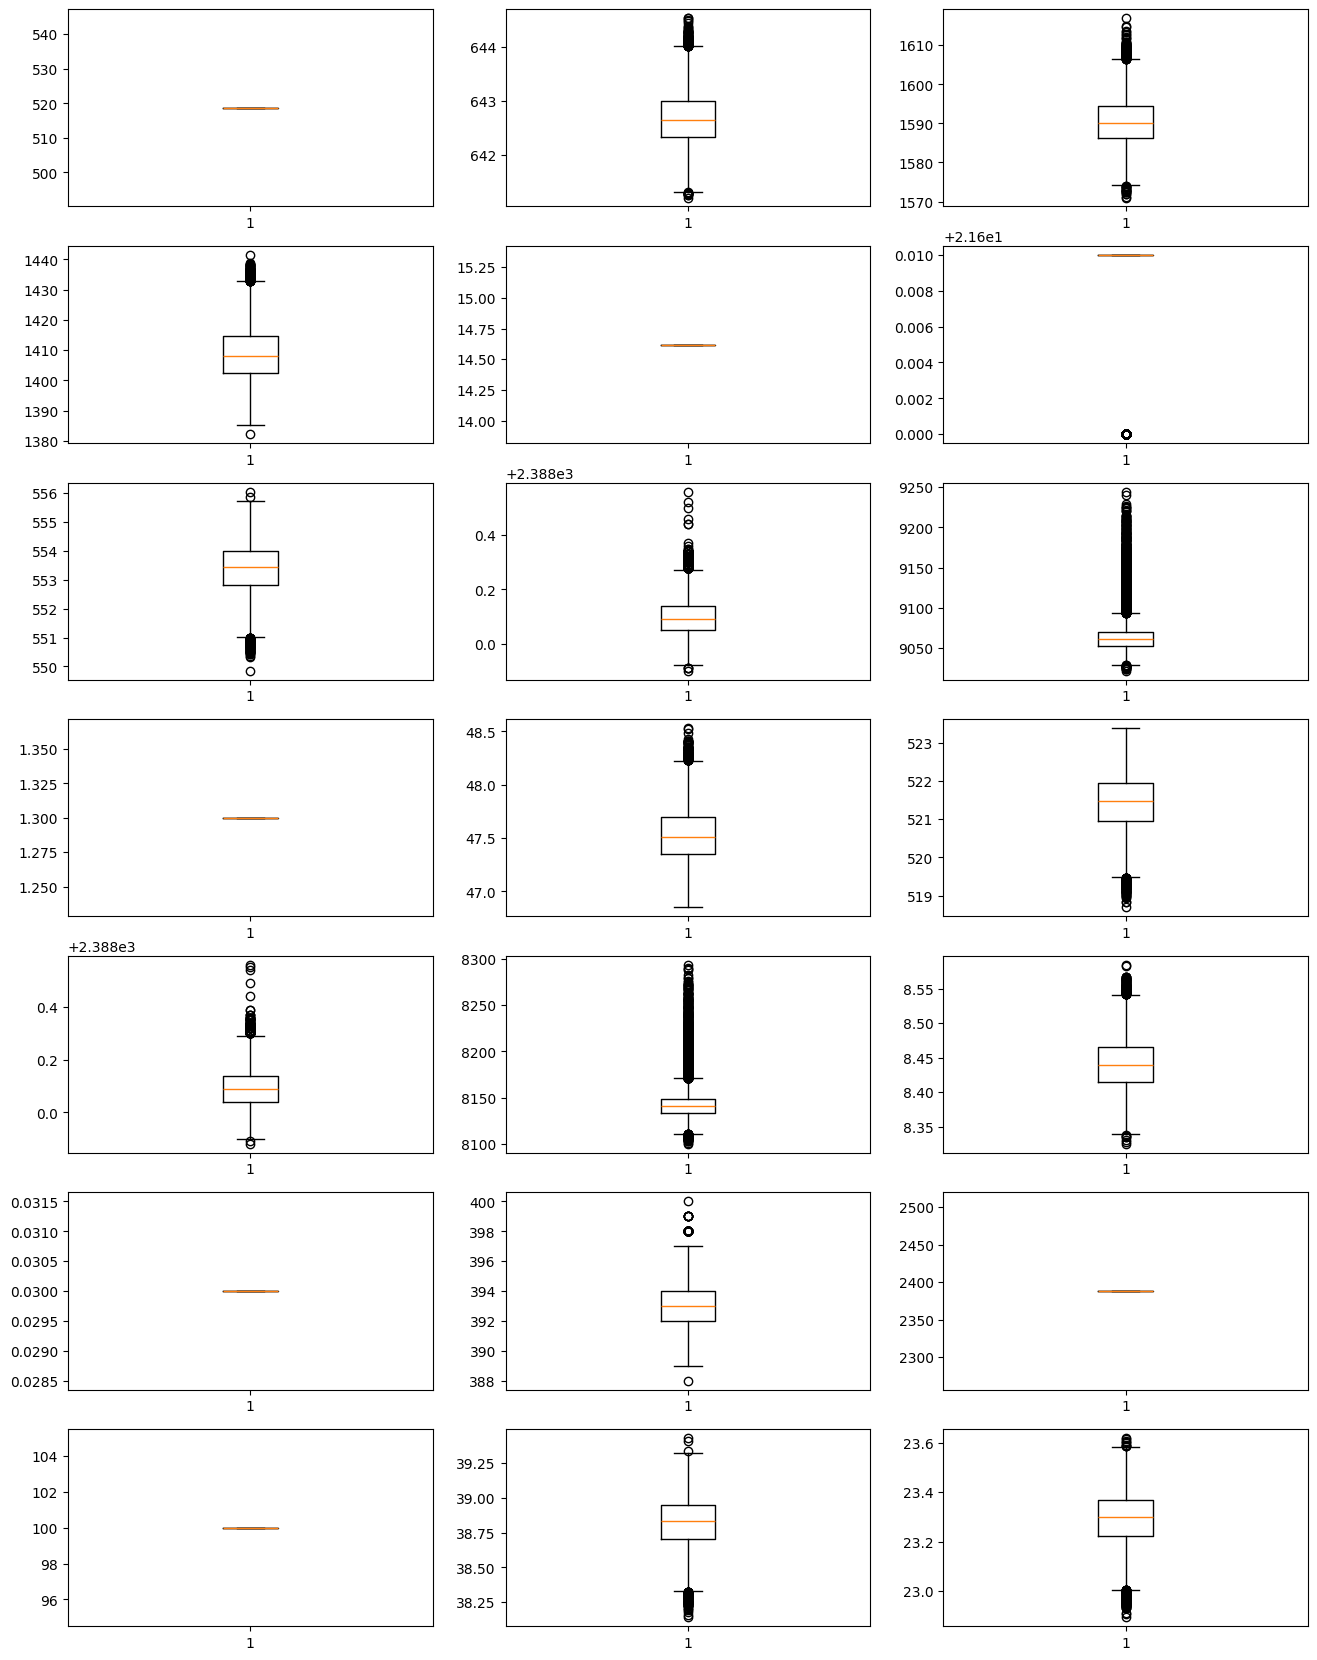

In [3]:
train_data = pd.read_csv("../CMAPSS/train_FD001.txt", sep= "\s+", header = None)
plt.figure(figsize = (16, 21))
for i in range(21):
    temp_data = train_data.iloc[:,i+5]
    plt.subplot(7,3,i+1)
    plt.boxplot(temp_data)
plt.show()

In [4]:
def process_targets(data_length, early_rul = None):
    if early_rul == None:
        return np.arange(data_length-1, -1, -1)
    else:
        early_rul_duration = data_length - early_rul
        if early_rul_duration <= 0:
            return np.arange(data_length-1, -1, -1)
        else:
            return np.append(early_rul*np.ones(shape = (early_rul_duration,)), np.arange(early_rul-1, -1, -1))

In [5]:
def process_input_data_with_targets(input_data, target_data = None, window_length = 1, shift = 1):
    """Depending on values of window_length and shift, this function generates batchs of data and targets 
    from input_data and target_data.
    
    Number of batches = np.floor((len(input_data) - window_length)/shift) + 1
    
    **We don't check input dimensions uisng exception handling. So readers should be careful while using these
    functions. If input data are not of desired dimension, either error occurs or something undesirable is 
    produced as output.**
    
    Arguments:
        input_data: input data to function (Must be 2 dimensional)
        target_data: input rul values (Must be 1D array)s
        window_length: window length of data
        shift: Distance by which the window moves for next batch. This is closely related to overlap
               between data. For example, if window length is 30 and shift is 1, there is an overlap of 
               29 data points between two consecutive batches.
        
    """
    num_batches = int(np.floor((len(input_data) - window_length)/shift)) + 1
    num_features = input_data.shape[1]
    output_data = np.repeat(np.nan, repeats = num_batches * window_length * num_features).reshape(num_batches, window_length,
                                                                                                  num_features)
    if target_data is None:
        for batch in range(num_batches):
            output_data[batch,:,:] = input_data[(0+shift*batch):(0+shift*batch+window_length),:]
        return output_data
    else:
        output_targets = np.repeat(np.nan, repeats = num_batches)
        for batch in range(num_batches):
            output_data[batch,:,:] = input_data[(0+shift*batch):(0+shift*batch+window_length),:]
            output_targets[batch] = target_data[(shift*batch + (window_length-1))]
        return output_data, output_targets

In [6]:
def process_test_data(test_data_for_an_engine, window_length, shift, num_test_windows = 1):
    """ This function takes test data for an engine as first input. The next two inputs
    window_length and shift are same as other functins. 
    
    Finally it takes num_test_windows as the last input. num_test_windows sets how many examplles we
    want from test data (from last). By default it extracts only the last example.
    
    The function return last examples and number of last examples (a scaler) as output. 
    We need the second output later. If we are extracting more than 1 last examples, we have to 
    average their prediction results. The second scaler halps us do just that.
    """
    max_num_test_batches = int(np.floor((len(test_data_for_an_engine) - window_length)/shift)) + 1
    if max_num_test_batches < num_test_windows:
        required_len = (max_num_test_batches -1)* shift + window_length
        batched_test_data_for_an_engine = process_input_data_with_targets(test_data_for_an_engine[-required_len:, :],
                                                                          target_data = None,
                                                                          window_length = window_length, shift = shift)
        return batched_test_data_for_an_engine, max_num_test_batches
    else:
        required_len = (num_test_windows - 1) * shift + window_length
        batched_test_data_for_an_engine = process_input_data_with_targets(test_data_for_an_engine[-required_len:, :],
                                                                          target_data = None,
                                                                          window_length = window_length, shift = shift)
        return batched_test_data_for_an_engine, num_test_windows

In the following cell, we will apply `MinMaxScaling` to the full trianing dataset.

In [7]:
test_data = pd.read_csv("../CMAPSS/test_FD001.txt", sep = "\s+", header = None)
true_rul = pd.read_csv("../CMAPSS/RUL_FD001.txt", sep = '\s+', header = None)

window_length = 30 #corretta
shift = 1 #corretta
early_rul = 125        #corretta    
processed_train_data = []
processed_train_targets = []

# How many test windows to take for each engine. If set to 1 (this is the default), only last window of test data for 
# each engine is taken. If set to a different number, that many windows from last are taken. 
# Final output is the average output of all windows.
num_test_windows = 5     
processed_test_data = []
num_test_windows_list = []

columns_to_be_dropped = [0,1,2,3,4,5,9,10,14,20,22,23]

train_data_first_column = train_data[0]
test_data_first_column = test_data[0]

# Scale data for all engines
scaler = MinMaxScaler(feature_range = (-1,1))
train_data = scaler.fit_transform(train_data.drop(columns = columns_to_be_dropped))
test_data = scaler.transform(test_data.drop(columns = columns_to_be_dropped))

train_data = pd.DataFrame(data = np.c_[train_data_first_column, train_data])
test_data = pd.DataFrame(data = np.c_[test_data_first_column, test_data])

num_train_machines = len(train_data[0].unique())
num_test_machines = len(test_data[0].unique())

# Process training and test data sepeartely as number of engines in training and test set may be different.
# As we are doing scaling for full dataset, we are not bothered by different number of engines in training and test set.

# Process trianing data
for i in np.arange(1, num_train_machines + 1):
    temp_train_data = train_data[train_data[0] == i].drop(columns = [0]).values
    
    # Verify if data of given window length can be extracted from training data
    if (len(temp_train_data) < window_length):
        print("Train engine {} doesn't have enough data for window_length of {}".format(i, window_length))
        raise AssertionError("Window length is larger than number of data points for some engines. "
                             "Try decreasing window length.")
        
    temp_train_targets = process_targets(data_length = temp_train_data.shape[0], early_rul = early_rul)
    data_for_a_machine, targets_for_a_machine = process_input_data_with_targets(temp_train_data, temp_train_targets, 
                                                                                window_length = window_length, shift = shift)
    
    processed_train_data.append(data_for_a_machine)
    processed_train_targets.append(targets_for_a_machine)

processed_train_data = np.concatenate(processed_train_data)
processed_train_targets = np.concatenate(processed_train_targets)

# Process test data
for i in np.arange(1, num_test_machines + 1):
    temp_test_data = test_data[test_data[0] == i].drop(columns = [0]).values
    
    # Verify if data of given window length can be extracted from test data
    if (len(temp_test_data) < window_length):
        print("Test engine {} doesn't have enough data for window_length of {}".format(i, window_length))
        raise AssertionError("Window length is larger than number of data points for some engines. "
                             "Try decreasing window length.")
    
    # Prepare test data
    test_data_for_an_engine, num_windows = process_test_data(temp_test_data, window_length = window_length, shift = shift,
                                                             num_test_windows = num_test_windows)
    
    processed_test_data.append(test_data_for_an_engine)
    num_test_windows_list.append(num_windows)

processed_test_data = np.concatenate(processed_test_data)
true_rul = true_rul[0].values

# Shuffle training data
index = np.random.permutation(len(processed_train_targets))
processed_train_data, processed_train_targets = processed_train_data[index], processed_train_targets[index]

print("Processed trianing data shape: ", processed_train_data.shape)
print("Processed training ruls shape: ", processed_train_targets.shape)
print("Processed test data shape: ", processed_test_data.shape)
print("True RUL shape: ", true_rul.shape)

print(type(processed_train_data))
print(type(processed_test_data))
print(type(processed_train_targets))
print(type(true_rul))

np.save("processed_test_data_np",processed_test_data)
np.save("processed_test_RUL_np", true_rul)

Processed trianing data shape:  (17731, 30, 14)
Processed training ruls shape:  (17731,)
Processed test data shape:  (497, 30, 14)
True RUL shape:  (100,)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


## Training and validation split

We will take 20% of training data (sampled randomly) as our validation set. We will monitor the training of our model using the validation set.

In [8]:
processed_train_data, processed_val_data, processed_train_targets, processed_val_targets = train_test_split(processed_train_data,
                                                                                                            processed_train_targets,
                                                                                                            test_size = 0.2,
                                                                                                            random_state = 83)
print("Processed train data shape: ", processed_train_data.shape)
print("Processed validation data shape: ", processed_val_data.shape)
print("Processed train targets shape: ", processed_train_targets.shape)
print("Processed validation targets shape: ", processed_val_targets.shape)

Processed train data shape:  (14184, 30, 14)
Processed validation data shape:  (3547, 30, 14)
Processed train targets shape:  (14184,)
Processed validation targets shape:  (3547,)


## LSTM

In [9]:
def custom_loss(y_true, y_pred):
    alpha = 0.2
    difference = y_pred - y_true
    squared_difference = tf.square(y_pred - y_true)
    
    # Calcola la loss per ciascun elemento
    loss = tf.where(difference < 0, 2 * alpha * squared_difference, 2 * (alpha + (1 - 2 * alpha)) * squared_difference)
    
    # Calcola la media delle loss
    return tf.reduce_mean(loss)

In [10]:
from keras.layers import LSTM, Flatten, Dense
from keras.optimizers import Adam
from keras import regularizers 
def create_compiled_model():
    model = Sequential([
        layers.LSTM(128, input_shape = (window_length, 14), return_sequences=True, activation = "tanh"),
        layers.LSTM(64, activation = "tanh", return_sequences = True),
        layers.LSTM(32, activation = "tanh"),
        layers.Dense(96, activation = "relu"),
        layers.Dense(128, activation = "relu"),
        layers.Dense(1)
    ])
    model.compile(loss = "mse", optimizer = tf.keras.optimizers.Adam(learning_rate=0.001))
    return model

def createLSTMsmallModel(l1Nodes, l2Nodes, d1Nodes, d2Nodes, input_shape):
    # input layer
    lstm1 = LSTM(l1Nodes, input_shape=input_shape,activation='tanh', return_sequences=True, kernel_regularizer=regularizers.l2(0.1))
    
    lstm2 = LSTM(l2Nodes, return_sequences=True, activation='tanh', kernel_regularizer=regularizers.l2(0.1))    
    flatten = Flatten()
    dense1 = Dense(d1Nodes, activation='relu', kernel_regularizer=regularizers.l2(0.1))
    dense2 = Dense(d2Nodes, activation='relu', kernel_regularizer=regularizers.l2(0.1))
    
    # output layer
    outL = Dense(1, activation='relu', kernel_regularizer=regularizers.l2(0.1))
    
    #layers
    layers = [lstm1, lstm2,flatten,  dense1, dense2, outL]
    model = Sequential(layers)
    #Abbiamo aggiunto le nostre funzioni di loss e accuracy definite precedentemente

    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=custom_loss)
    return model

def createLSTMsmallModelMSE(l1Nodes, l2Nodes, d1Nodes, d2Nodes, input_shape):
    # input layer
    lstm1 = LSTM(l1Nodes, input_shape=input_shape,activation='tanh', return_sequences=True, kernel_regularizer=regularizers.l2(0.1))
    
    lstm2 = LSTM(l2Nodes, return_sequences=True, activation='tanh', kernel_regularizer=regularizers.l2(0.1))    
    flatten = Flatten()
    dense1 = Dense(d1Nodes, activation='relu', kernel_regularizer=regularizers.l2(0.1))
    dense2 = Dense(d2Nodes, activation='relu', kernel_regularizer=regularizers.l2(0.1))
    
    # output layer
    outL = Dense(1, activation='relu', kernel_regularizer=regularizers.l2(0.1))
    
    #layers
    layers = [lstm1, lstm2,flatten,  dense1, dense2, outL]
    model = Sequential(layers)
    #Abbiamo aggiunto le nostre funzioni di loss e accuracy definite precedentemente

    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss="mse")
    return model

We will use a learning rate scheduler that will decrease the learning rate after 10 epochs.

In [11]:
# def scheduler(epoch):
#     if epoch < 10:
#         return 0.001
#     else:
#         return 0.0001

def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    elif epoch >= 10 and epoch < 20 :
        return 0.001
    elif epoch >= 20 and epoch < 30: 
        return 0.0001
    elif epoch >= 30: 
        return 0.00001
    else: 
        return 0.01; 
    

In [12]:
callback = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose = 1)

In [13]:
EPOCHS = 50
BATCH_SIZE = 256

# model = create_compiled_model()

# history = model.fit(processed_train_data, processed_train_targets, epochs = EPOCHS,
#                     validation_data = (processed_val_data, processed_val_targets),
#                     callbacks = callback,
#                     batch_size = BATCH_SIZE, verbose = 2)



## LA PRIMA RETE È LA SMALL CON LA FUNZIONE DI LOSS QUAD-QUAD
lstm_small_quad = createLSTMsmallModel(60, 30, 30, 15, (30, 14))

history = lstm_small_quad.fit(processed_train_data, processed_train_targets, epochs = EPOCHS, 
                     validation_data = (processed_val_data, processed_val_targets), 
                     callbacks = callback, 
                     batch_size=BATCH_SIZE)


## lA SECONDA RETE È LA STESSA LSTM SMALL CON MSE
lstm_small_mse = createLSTMsmallModelMSE(60, 30, 30, 15, (30, 14))

history = lstm_small_mse.fit(processed_train_data, processed_train_targets, epochs = EPOCHS, 
                     validation_data = (processed_val_data, processed_val_targets), 
                     callbacks = callback, 
                     batch_size=BATCH_SIZE)

2023-12-27 15:28:29.241097: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-27 15:28:29.281013: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-27 15:28:29.281053: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-27 15:28:29.283771: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-27 15:28:29.283813: I tensorflow/compile


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/50


2023-12-27 15:28:32.774104: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-12-27 15:28:33.638289: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f459401bbf0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-27 15:28:33.638334: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2060 with Max-Q Design, Compute Capability 7.5
2023-12-27 15:28:33.648808: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-27 15:28:33.750619: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


56/56 [==============================] - 5s 31ms/step - loss: 1644.9393 - val_loss: 585.0918 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/50
56/56 [==============================] - 1s 19ms/step - loss: 386.4304 - val_loss: 289.5813 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/50
56/56 [==============================] - 1s 19ms/step - loss: 245.4931 - val_loss: 211.0764 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/50
56/56 [==============================] - 1s 19ms/step - loss: 224.6029 - val_loss: 222.3926 - lr: 0.0010

Epoch 5: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 5/50
56/56 [==============================] - 1s 19ms/step - loss: 201.5752 - val_loss: 180.1051 - lr: 0.0010

Epoch 6: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 6/50
56/56 [============

In [14]:
#QUAD-QUAD Network
rul_pred = lstm_small_quad.predict(processed_test_data).reshape(-1)
preds_for_each_engine = np.split(rul_pred, np.cumsum(num_test_windows_list)[:-1])
mean_pred_for_each_engine = [np.average(ruls_for_each_engine, weights = np.repeat(1/num_windows, num_windows)) 
                             for ruls_for_each_engine, num_windows in zip(preds_for_each_engine, num_test_windows_list)]
RMSE = np.sqrt(mean_squared_error(true_rul, mean_pred_for_each_engine))
print("RMSE: ", RMSE)

16/16 [==============================] - 1s 5ms/step
RMSE:  14.850870266473514


### Save the model

In [15]:
# tf.keras.models.save_model(lstm_small_quad, "FD001_LSTM_piecewise_RMSE_"+ str(np.round(RMSE, 4)) + ".h5")

We will now compute the RMSE by taking only last example of each engine.

In [16]:
indices_of_last_examples = np.cumsum(num_test_windows_list) - 1
preds_for_last_example = np.concatenate(preds_for_each_engine)[indices_of_last_examples]

RMSE_new = np.sqrt(mean_squared_error(true_rul, preds_for_last_example))
print("RMSE (Taking only last examples): ", RMSE_new)

RMSE (Taking only last examples):  15.87987869514948


In [17]:
def compute_s_score(rul_true, rul_pred):
    """
    Both rul_true and rul_pred should be 1D numpy arrays.
    """
    diff = rul_pred - rul_true
    return np.sum(np.where(diff < 0, np.exp(-diff/13)-1, np.exp(diff/10)-1))

In [18]:
s_score = compute_s_score(true_rul, preds_for_last_example)
print("S-score(QUAD-QUAD network): ", s_score)

S-score(QUAD-QUAD network):  343.46133019288106


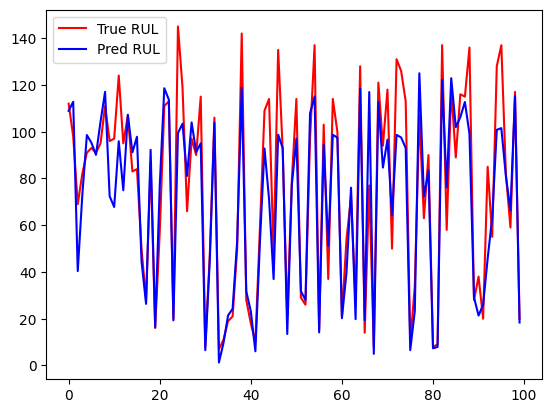

In [19]:
# Plot true and predicted RUL values
plt.plot(true_rul, label = "True RUL", color = "red")
plt.plot(preds_for_last_example, label = "Pred RUL", color = "blue")
plt.legend()
plt.show()

In [20]:
## MSE network
rul_pred = lstm_small_mse.predict(processed_test_data).reshape(-1)
preds_for_each_engine = np.split(rul_pred, np.cumsum(num_test_windows_list)[:-1])
mean_pred_for_each_engine = [np.average(ruls_for_each_engine, weights = np.repeat(1/num_windows, num_windows)) 
                             for ruls_for_each_engine, num_windows in zip(preds_for_each_engine, num_test_windows_list)]
RMSE = np.sqrt(mean_squared_error(true_rul, mean_pred_for_each_engine))
print("RMSE: ", RMSE)

16/16 [==============================] - 1s 5ms/step
RMSE:  14.738815791490087


In [21]:
indices_of_last_examples = np.cumsum(num_test_windows_list) - 1
preds_for_last_example = np.concatenate(preds_for_each_engine)[indices_of_last_examples]

RMSE_new = np.sqrt(mean_squared_error(true_rul, preds_for_last_example))
print("RMSE (Taking only last examples): ", RMSE_new)

RMSE (Taking only last examples):  14.646356139976335


In [22]:
s_score = compute_s_score(true_rul, preds_for_last_example)
print("S-score (MSE NETWORK): ", s_score)

S-score (MSE NETWORK):  415.0169630964355


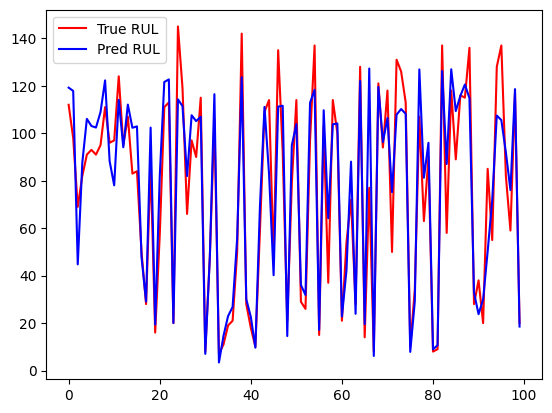

In [23]:
plt.plot(true_rul, label = "True RUL", color = "red")
plt.plot(preds_for_last_example, label = "Pred RUL", color = "blue")
plt.legend()
plt.show()

In [24]:
def custom_loss_large(y_true, y_pred):
    alpha = 0.4
    difference = y_pred - y_true
    squared_difference = tf.square(y_pred - y_true)
    
    # Calcola la loss per ciascun elemento
    loss = tf.where(difference < 0, 2 * alpha * squared_difference, 2 * (alpha + (1 - 2 * alpha)) * squared_difference)
    
    # Calcola la media delle loss
    return tf.reduce_mean(loss)

In [25]:
from keras.layers import Dropout

def createLSTMlargeModel(l1Nodes, l2Nodes, l3Nodes, l4Nodes, d1dense , d2dense, input_shape): 
    lstm1 = LSTM(l1Nodes, input_shape=input_shape, return_sequences=True, kernel_regularizer=regularizers.l2(0.1))
    d1 = Dropout(0.2)
    lstm2 = LSTM(l2Nodes, return_sequences=True, kernel_regularizer=regularizers.l2(0.1))
    d2 = Dropout(0.2)
    lstm3 = LSTM(l3Nodes, return_sequences=True, kernel_regularizer=regularizers.l2(0.1))
    d3 = Dropout(0.2)
    lstm4 = LSTM(l4Nodes, return_sequences=True, kernel_regularizer=regularizers.l2(0.1))
    d4 = Dropout(0.2)

    flatten = Flatten()

    dense1 = Dense(d1dense,activation='relu', kernel_regularizer=regularizers.l2(0.1))
    dense2 = Dense(d2dense,activation='relu', kernel_regularizer=regularizers.l2(0.1))
    output_dense = Dense(1,activation='relu', kernel_regularizer=regularizers.l2(0.1))

    layers = [lstm1,d1, lstm2,d2, lstm3, d3, lstm4, d4,flatten,  dense1, dense2, output_dense]
   
    
    model = Sequential(layers)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss=custom_loss_large)
    #model.compile(optimizer=optimizer, loss="mse", metrics = [custom_score])
    return model


In [26]:
LSTMlargeModel= createLSTMlargeModel(128, 64, 32, 16, 64, 32, (30,14))

In [27]:
def scheduler2(epoch, lr):
    if epoch < 30:
        return lr
    elif epoch >= 30 and epoch < 60 :
        return 0.001
    elif epoch >= 60 and epoch < 90: 
        return 0.0001
    elif epoch >= 90: 
        return 0.00001
    else: 
        return 0.01; 

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler2, verbose = 1)

In [28]:
EPOCHS = 100
history = LSTMlargeModel.fit(processed_train_data, 
                             processed_train_targets, 
                        epochs = EPOCHS, 
                     validation_data = (processed_val_data, processed_val_targets), 
                     callbacks = callback, 
                     batch_size=BATCH_SIZE)


Epoch 1: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 1/100
56/56 [==============================] - 8s 56ms/step - loss: 1636.8082 - val_loss: 917.1142 - lr: 0.0100

Epoch 2: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 2/100
56/56 [==============================] - 2s 37ms/step - loss: 822.1459 - val_loss: 831.4271 - lr: 0.0100

Epoch 3: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 3/100
56/56 [==============================] - 2s 37ms/step - loss: 712.1822 - val_loss: 619.5566 - lr: 0.0100

Epoch 4: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 4/100
56/56 [==============================] - 2s 37ms/step - loss: 625.6870 - val_loss: 514.8560 - lr: 0.0100

Epoch 5: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 5/100
56/56 [==============================] - 2s 38ms/step - loss: 383.8299 - val_loss: 441.1683 - lr: 0.0100

Epoch 6: LearningR

In [29]:
rul_pred = LSTMlargeModel.predict(processed_test_data).reshape(-1)
preds_for_each_engine = np.split(rul_pred, np.cumsum(num_test_windows_list)[:-1])
mean_pred_for_each_engine = [np.average(ruls_for_each_engine, weights = np.repeat(1/num_windows, num_windows)) 
                             for ruls_for_each_engine, num_windows in zip(preds_for_each_engine, num_test_windows_list)]
RMSE = np.sqrt(mean_squared_error(true_rul, mean_pred_for_each_engine))
print("RMSE (LARGE MODEL QUAD): ", RMSE)

16/16 [==============================] - 1s 8ms/step
RMSE (LARGE MODEL QUAD):  14.235035130805638


In [30]:
indices_of_last_examples = np.cumsum(num_test_windows_list) - 1
preds_for_last_example = np.concatenate(preds_for_each_engine)[indices_of_last_examples]

RMSE_new = np.sqrt(mean_squared_error(true_rul, preds_for_last_example))
print("RMSE (Taking only last examples): ", RMSE_new)

RMSE (Taking only last examples):  14.726988271401085


In [31]:
s_score = compute_s_score(true_rul, preds_for_last_example)
print("S-score (LARGE MODEL QUAD): ", s_score)

S-score (LARGE MODEL QUAD):  369.4973608279579


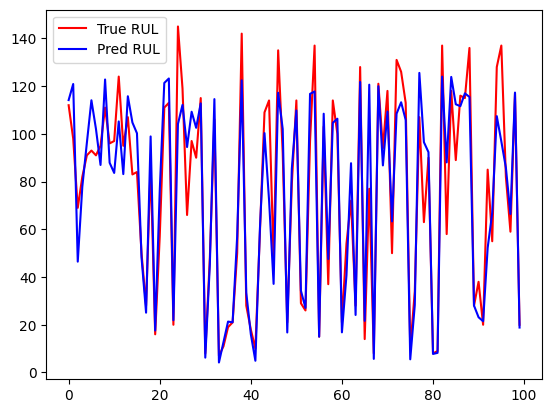

In [32]:
plt.plot(true_rul, label = "True RUL", color = "red")
plt.plot(preds_for_last_example, label = "Pred RUL", color = "blue")
plt.legend()
plt.show()

In [33]:
def createLSTMlargeModelMSE(l1Nodes, l2Nodes, l3Nodes, l4Nodes, d1dense , d2dense, input_shape): 
    lstm1 = LSTM(l1Nodes, input_shape=input_shape, return_sequences=True, kernel_regularizer=regularizers.l2(0.1))
    d1 = Dropout(0.2)
    lstm2 = LSTM(l2Nodes, return_sequences=True, kernel_regularizer=regularizers.l2(0.1))
    d2 = Dropout(0.2)
    lstm3 = LSTM(l3Nodes, return_sequences=True, kernel_regularizer=regularizers.l2(0.1))
    d3 = Dropout(0.2)
    lstm4 = LSTM(l4Nodes, return_sequences=True, kernel_regularizer=regularizers.l2(0.1))
    d4 = Dropout(0.2)

    flatten = Flatten()

    dense1 = Dense(d1dense,activation='relu', kernel_regularizer=regularizers.l2(0.1))
    dense2 = Dense(d2dense,activation='relu', kernel_regularizer=regularizers.l2(0.1))
    output_dense = Dense(1,activation='relu', kernel_regularizer=regularizers.l2(0.1))

    layers = [lstm1,d1, lstm2,d2, lstm3, d3, lstm4, d4,flatten,  dense1, dense2, output_dense]
   
    
    model = Sequential(layers)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss=custom_loss_large)
    #model.compile(optimizer=optimizer, loss="mse", metrics = [custom_score])
    return model

In [34]:
LSTMlargeModelMSE= createLSTMlargeModelMSE(128, 64, 32, 16, 64, 32, (30,14))

In [35]:
EPOCHS = 100
history = LSTMlargeModelMSE.fit(processed_train_data, 
                             processed_train_targets, 
                        epochs = EPOCHS, 
                     validation_data = (processed_val_data, processed_val_targets), 
                     callbacks = callback, 
                     batch_size=BATCH_SIZE)


Epoch 1: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 1/100
56/56 [==============================] - 8s 58ms/step - loss: 1593.6665 - val_loss: 622.8926 - lr: 0.0100

Epoch 2: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 2/100
56/56 [==============================] - 2s 37ms/step - loss: 624.2349 - val_loss: 457.0118 - lr: 0.0100

Epoch 3: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 3/100
56/56 [==============================] - 2s 37ms/step - loss: 401.2362 - val_loss: 418.4134 - lr: 0.0100

Epoch 4: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 4/100
56/56 [==============================] - 2s 37ms/step - loss: 343.8294 - val_loss: 285.5459 - lr: 0.0100

Epoch 5: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 5/100
56/56 [==============================] - 2s 37ms/step - loss: 282.6375 - val_loss: 252.1128 - lr: 0.0100

Epoch 6: LearningR

In [36]:
rul_pred = LSTMlargeModelMSE.predict(processed_test_data).reshape(-1)
preds_for_each_engine = np.split(rul_pred, np.cumsum(num_test_windows_list)[:-1])
mean_pred_for_each_engine = [np.average(ruls_for_each_engine, weights = np.repeat(1/num_windows, num_windows)) 
                             for ruls_for_each_engine, num_windows in zip(preds_for_each_engine, num_test_windows_list)]
RMSE = np.sqrt(mean_squared_error(true_rul, mean_pred_for_each_engine))
print("RMSE (LARGE MODEL MSE): ", RMSE)

16/16 [==============================] - 1s 8ms/step
RMSE (LARGE MODEL MSE):  14.403937229592849


In [37]:
indices_of_last_examples = np.cumsum(num_test_windows_list) - 1
preds_for_last_example = np.concatenate(preds_for_each_engine)[indices_of_last_examples]

RMSE_new = np.sqrt(mean_squared_error(true_rul, preds_for_last_example))
print("RMSE (Taking only last examples): ", RMSE_new)

RMSE (Taking only last examples):  15.12036563981932


In [38]:
s_score = compute_s_score(true_rul, preds_for_last_example)
print("S-score (LARGE MODEL MSE): ", s_score)

S-score (LARGE MODEL MSE):  338.3563777905306


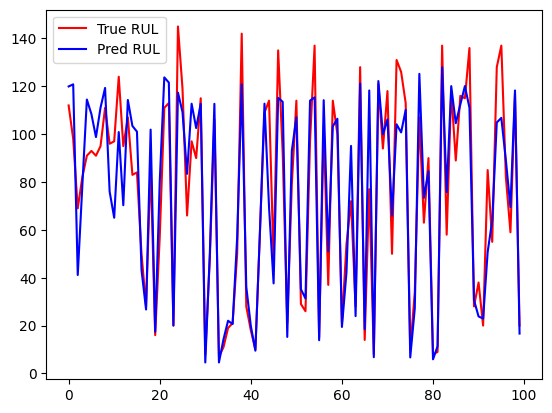

In [39]:
plt.plot(true_rul, label = "True RUL", color = "red")
plt.plot(preds_for_last_example, label = "Pred RUL", color = "blue")
plt.legend()
plt.show()

In [40]:
from tflite_converter import convert_to_tflite
MODEL_DIR = './models/FD001/LSTMsmall/QUAD-QUAD/'
BATCH_SIZE = 1
STEPS = 30 
INPUT_SIZE = 14
nome = "lstm_small_batch_1"
convert_to_tflite(MODEL_DIR, BATCH_SIZE, STEPS, INPUT_SIZE, lstm_small_quad, nome)

INFO:tensorflow:Assets written to: ./models/FD001/LSTMsmall/QUAD-QUAD/assets


INFO:tensorflow:Assets written to: ./models/FD001/LSTMsmall/QUAD-QUAD/assets
2023-12-27 15:37:42.228873: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2023-12-27 15:37:42.228945: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2023-12-27 15:37:42.229881: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: ./models/FD001/LSTMsmall/QUAD-QUAD/
2023-12-27 15:37:42.243433: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2023-12-27 15:37:42.243464: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: ./models/FD001/LSTMsmall/QUAD-QUAD/
2023-12-27 15:37:42.271304: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:382] MLIR V1 optimization pass is not enabled
2023-12-27 15:37:42.283252: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2023-12-27 15:37:42.396791: I tensor

In [41]:

MODEL_DIR = './models/FD001/LSTMsmall/MSE/'
BATCH_SIZE = 1
STEPS = 30 
INPUT_SIZE = 14
nome = "lstm_small_batch_1_MSE"
convert_to_tflite(MODEL_DIR, BATCH_SIZE, STEPS, INPUT_SIZE, lstm_small_mse, nome)

INFO:tensorflow:Assets written to: ./models/FD001/LSTMsmall/MSE/assets


INFO:tensorflow:Assets written to: ./models/FD001/LSTMsmall/MSE/assets
2023-12-27 15:37:48.206231: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2023-12-27 15:37:48.206289: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2023-12-27 15:37:48.206467: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: ./models/FD001/LSTMsmall/MSE/
2023-12-27 15:37:48.218691: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2023-12-27 15:37:48.218726: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: ./models/FD001/LSTMsmall/MSE/
2023-12-27 15:37:48.255359: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2023-12-27 15:37:48.369955: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: ./models/FD001/LSTMsmall/MSE/
2023-12-27 15:37:48.444806: I 

In [42]:

MODEL_DIR = './models/FD001/LSTMlarge/QUAD-QUAD/'
BATCH_SIZE = 1
STEPS = 30 
INPUT_SIZE = 14
nome = "lstm_large_batch_1_QUAD"
convert_to_tflite(MODEL_DIR, BATCH_SIZE, STEPS, INPUT_SIZE, LSTMlargeModel, nome)

INFO:tensorflow:Assets written to: ./models/FD001/LSTMlarge/QUAD-QUAD/assets


INFO:tensorflow:Assets written to: ./models/FD001/LSTMlarge/QUAD-QUAD/assets
2023-12-27 15:38:00.137041: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2023-12-27 15:38:00.137091: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2023-12-27 15:38:00.137270: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: ./models/FD001/LSTMlarge/QUAD-QUAD/
2023-12-27 15:38:00.157238: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2023-12-27 15:38:00.157271: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: ./models/FD001/LSTMlarge/QUAD-QUAD/
2023-12-27 15:38:00.223285: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2023-12-27 15:38:00.432045: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: ./models/FD001/LSTMlarge/QUAD-QUAD/
2023-1

In [43]:

MODEL_DIR = './models/FD001/LSTMlarge/MSE/'
BATCH_SIZE = 1
STEPS = 30 
INPUT_SIZE = 14
nome = "lstm_large_batch_1_MSE"
convert_to_tflite(MODEL_DIR, BATCH_SIZE, STEPS, INPUT_SIZE, LSTMlargeModelMSE, nome)

INFO:tensorflow:Assets written to: ./models/FD001/LSTMlarge/MSE/assets


INFO:tensorflow:Assets written to: ./models/FD001/LSTMlarge/MSE/assets
2023-12-27 15:38:12.246503: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2023-12-27 15:38:12.246558: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2023-12-27 15:38:12.246736: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: ./models/FD001/LSTMlarge/MSE/
2023-12-27 15:38:12.270846: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2023-12-27 15:38:12.270879: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: ./models/FD001/LSTMlarge/MSE/
2023-12-27 15:38:12.349429: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2023-12-27 15:38:12.547930: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: ./models/FD001/LSTMlarge/MSE/
2023-12-27 15:38:12.684682: I 

## CNNs

In [3]:
from keras.layers import Conv1D, MaxPooling1D
cnn_small = Sequential()
cnn_small.add(Conv1D(filters=64, kernel_size=8, activation='relu', input_shape=(30, 14)))
cnn_small.add(Conv1D(filters=32, kernel_size=6, activation='relu'))
cnn_small.add(Conv1D(filters=16, kernel_size=3, activation='relu'))
cnn_small.add(MaxPooling1D(pool_size=2))
cnn_small.add(Flatten())
cnn_small.add(Dense(units=32, activation='relu'))
cnn_small.add(Dense(units=1, activation='relu'))

cnn_small.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss=custom_loss)  # Puoi scegliere un altro ottimizzatore e una metrica diversa

NameError: name 'Sequential' is not defined

In [ ]:
EPOCHS = 80 #150 per la large
BATCH_SIZE = 256 #512 per la large


history = cnn_small.fit(processed_train_data, 
                             processed_train_targets, 
                        epochs = EPOCHS, 
                     validation_data = (processed_val_data, processed_val_targets), 
                     batch_size=BATCH_SIZE)

In [ ]:
rul_pred = cnn_small.predict(processed_test_data).reshape(-1)
preds_for_each_engine = np.split(rul_pred, np.cumsum(num_test_windows_list)[:-1])
mean_pred_for_each_engine = [np.average(ruls_for_each_engine, weights = np.repeat(1/num_windows, num_windows)) 
                             for ruls_for_each_engine, num_windows in zip(preds_for_each_engine, num_test_windows_list)]
RMSE = np.sqrt(mean_squared_error(true_rul, mean_pred_for_each_engine))
print("RMSE (LARGE MODEL MSE): ", RMSE)